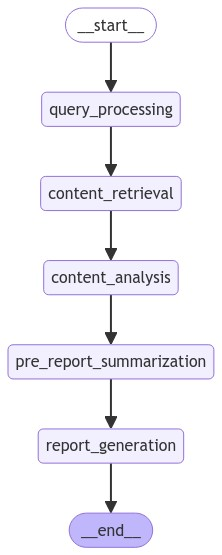

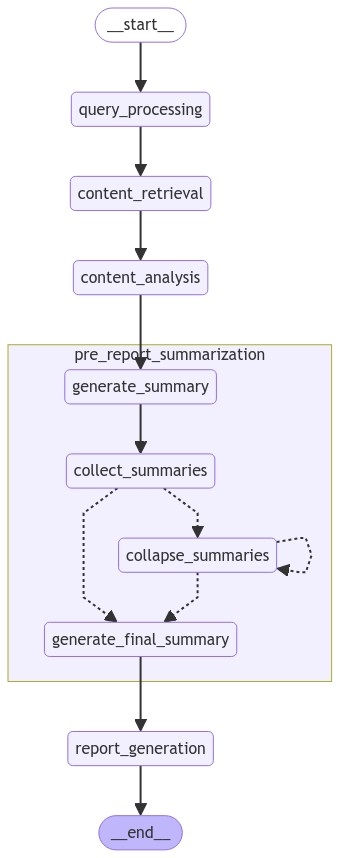

2024-08-23 18:26:32,840 - INFO - Starting step: process_query
2024-08-23 18:26:32,846 - INFO - Finished step: process_query (Time taken: 0.01 seconds)
2024-08-23 18:26:32,849 - INFO - Starting step: retrieve_content
An error occurred while processing https://lakefs.io/blog/python-data-pipeline/: Server disconnected
2024-08-23 18:26:33,751 - INFO - Finished step: retrieve_content (Time taken: 0.90 seconds)
2024-08-23 18:26:33,754 - INFO - Starting step: analyze_content
2024-08-23 18:26:33,761 - INFO - Finished step: analyze_content (Time taken: 0.01 seconds)
2024-08-23 18:26:33,771 - INFO - Starting step: generate_summary
2024-08-23 18:26:33,771 - INFO - Starting step: generate_summary
2024-08-23 18:26:36,324 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-08-23 18:26:36,337 - INFO - Finished step: generate_summary (Time taken: 2.56 seconds)
2024-08-23 18:26:38,495 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/

In [1]:
import sys

sys.path.append("../")


from reportgen_agent.utils import wrap_node_with_logging
from reportgen_agent.core.graph import create_pre_report_summarization_graph
from reportgen_agent.utils.storage_utils import create_run_directory, save_state
from reportgen_agent.nodes.final_review import review_final_output
from reportgen_agent.nodes.output_refinement import refine_output
from reportgen_agent.nodes.source_citation import add_citations
from reportgen_agent.nodes.report_generation import generate_report
from reportgen_agent.nodes.content_analysis import analyze_content
from reportgen_agent.nodes.content_retrieval import retrieve_content
from reportgen_agent.nodes.web_search import perform_web_search_node
from reportgen_agent.nodes.query_processing import process_query
from reportgen_agent.core.state import ReportGenState
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, END
import logging
import time
import sqlite3
from typing import List


def main(query: str, search_results: List[str], analyzed_content=List[str]):
    run_dir, run_id = create_run_directory()

    initial_state = ReportGenState(
        query=query,
        keywords=[],
        expanded_concepts=[],
        search_results=search_results,
        retrieved_content=[],
        filtered_content=[],
        analyzed_content=analyzed_content,
        markdown_report="",
    )

    graph = StateGraph(ReportGenState)
    pre_report_summarization_graph = create_pre_report_summarization_graph(
        run_dir + "/pre_report_summarization"
    )

    ###########
    ## NODES ##
    ###########
    graph.add_node("query_processing", wrap_node_with_logging(process_query, run_dir))
    # graph.add_node("web_search", perform_web_search_node)
    graph.add_node(
        "content_retrieval",
        wrap_node_with_logging(retrieve_content, run_dir),
    )
    graph.add_node("content_analysis", wrap_node_with_logging(analyze_content, run_dir))
    graph.add_node(
        "pre_report_summarization",
        pre_report_summarization_graph.compile(),
    )
    graph.add_node(
        "report_generation", wrap_node_with_logging(generate_report, run_dir)
    )
    # graph.add_node("source_citation", add_citations)
    # graph.add_node("output_refinement", refine_output)
    # graph.add_node("final_review", review_final_output)

    ###########
    ## EDGES ##
    ###########
    # graph.add_edge("query_processing", "pre_report_summarization")
    # graph.add_edge("query_processing", "web_search")
    # graph.add_edge("web_search", "content_retrieval")
    graph.add_edge("query_processing", "content_retrieval")
    graph.add_edge("content_retrieval", "content_analysis")
    graph.add_edge("content_analysis", "pre_report_summarization")
    graph.add_edge("pre_report_summarization", "report_generation")
    # graph.add_edge("report_generation", "source_citation")
    # graph.add_edge("source_citation", "output_refinement")
    # graph.add_edge("output_refinement", "final_review")

    graph.set_entry_point("query_processing")
    # graph.set_entry_point("content_retrieval")
    # graph.set_finish_point("final_review")
    graph.add_edge("report_generation", END)

    conn = sqlite3.connect("../data/checkpoints.sqlite", check_same_thread=False)
    memory = SqliteSaver(conn)

    compiled_graph = graph.compile(checkpointer=memory)

    from IPython.display import Image, display
    from langchain_core.runnables.graph import MermaidDrawMethod

    display(
        Image(
            compiled_graph.get_graph().draw_mermaid_png(
                output_file_path="agent_graph.png",
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
    display(
        Image(
            compiled_graph.get_graph(xray=1).draw_mermaid_png(
                output_file_path="agent_graph-detailed.png",
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
    # print(compiled_graph.get_graph().draw_mermaid())

    # Execute the graph with the initial state
    result = compiled_graph.invoke(
        initial_state,
        {"configurable": {"thread_id": "1"}},
    )

    # # Print the final output (e.g., the generated Markdown report)
    print("Generated Report:")
    print(result["markdown_report"])


urls2fetch = [
    "https://lakefs.io/blog/python-data-pipeline/",
    "https://dataheadhunters.com/academy/how-to-create-data-pipelines-in-python-a-comprehensive-tutorial/",
    "https://www.integrate.io/blog/building-an-etl-pipeline-in-python/",
    # "https://airbyte.com/top-etl-tools-for-sources/python-etl-tools/",
    # "https://medium.com/@iftimiealexandru/data-pipeline-recipes-in-python-8561e07b2556",
    # "https://konfuzio.com/en/python-data-pipeline/",
    # "https://peliqan.io/blog/best-data-pipeline-tools/",
    # "https://hevodata.com/learn/python-etl-tools/",
    # "https://www.reddit.com/r/BusinessIntelligence/comments/1623bnq/where_to_start_with_python_for_data_pipelines/",
    # "https://blog.panoply.io/top-9-python-etl-tools-and-when-to-use-them",
    # "https://github.com/Nike-Inc/koheesio",
    # "https://www.astera.com/type/blog/python-etl-tools/",
    # "https://arismuhandisin.medium.com/navigating-the-world-of-data-pipeline-tools-and-technologies-b1dc2b3e06b1",
    # "https://www.integrate.io/blog/comparison-of-the-top-python-etl-tools/",
]


main(
    query="What are the available python tools for building pipelines?",
    search_results=[{"url": url} for url in urls2fetch],
    # analyzed_content=analyzed_content,
    analyzed_content=[],
)

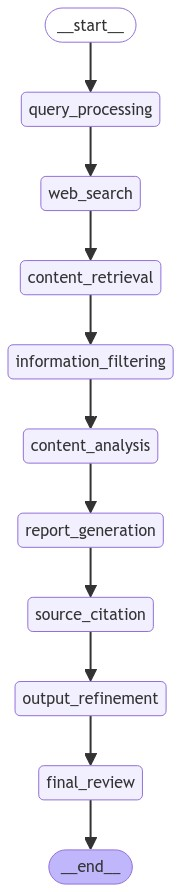

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from reportgen_agent.core.graph import create_graph

graph = create_graph()
graph_compiled = graph.compile()
display(
    Image(
        graph_compiled.get_graph().draw_mermaid_png(
            output_file_path="graph.png",
            draw_method=MermaidDrawMethod.API,
        )
    )
)
print(graph_compiled.get_graph().draw_mermaid())

In [ ]:
from reportgen_agent.core.state import ReportGenState
from reportgen_agent.core.graph import create_graph
import os
import sys
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Ensure that the reportgen_agent module is accessible
sys.path.append(os.path.abspath(".."))

In [ ]:
# Step 2: Define the functions to test the entire graph


def test_full_graph():
    """Test the entire graph workflow."""
    graph = create_graph()
    compiled_graph = graph.compile()

    initial_state = {
        "query": "How does Python handle memory management?",
        "keywords": [],
        "expanded_concepts": [],
        "search_results": [],
        "retrieved_content": [],
        "filtered_content": [],
        "analyzed_content": [],
        "markdown_report": "",
    }

    result = compiled_graph.invoke(initial_state)
    display(Markdown(result["markdown_report"]))

In [ ]:
# Step 3: Define the functions to test individual parts of the graph


def test_query_processing():
    """Test the query processing part of the graph."""
    from reportgen_agent.nodes.query_processing import query_processing

    state = ReportGenState(
        query="What is Python?",
        keywords=[],
        expanded_concepts=[],
        search_results=[],
        retrieved_content=[],
        filtered_content=[],
        analyzed_content=[],
        markdown_report="",
    )
    result_state = query_processing(state)
    display(Markdown(f"Keywords: {result_state['keywords']}"))
    display(Markdown(f"Expanded Concepts: {result_state['expanded_concepts']}"))


def test_web_search():
    """Test the web search part of the graph."""
    from reportgen_agent.nodes.web_search import web_search

    state = ReportGenState(
        query="What is Python?",
        keywords=["Python", "programming"],
        expanded_concepts=["Python", "programming language"],
        search_results=[],
        retrieved_content=[],
        filtered_content=[],
        analyzed_content=[],
        markdown_report="",
    )
    result_state = web_search(state)
    display(Markdown(f"Search Results: {result_state['search_results']}"))


# Similarly, you can define test functions for other nodes in your graph.

In [ ]:
# Step 4: Function to visualize the graph


def visualize_graph():
    """Visualize the structure of the graph."""
    graph = create_graph()

    # Extract nodes and edges
    nodes = graph.nodes
    edges = graph.edges

    G = nx.DiGraph()

    for node in nodes:
        G.add_node(node)

    for edge in edges:
        G.add_edge(edge[0], edge[1])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="skyblue",
        node_size=2000,
        edge_color="gray",
        linewidths=2,
        font_size=15,
    )
    plt.show()

In [ ]:
# Step 5: Testing the entire graph workflow
print("Testing the full graph workflow...")
test_full_graph()

In [ ]:
# Step 6: Testing individual parts of the graph
print("Testing the query processing node...")
test_query_processing()

print("Testing the web search node...")
test_web_search()

In [ ]:
# Step 7: Visualizing the graph
print("Visualizing the graph structure...")
visualize_graph()